# Solutions - Homework 6

## Markets Foundations

### UChicago Financial Mathematics

#### September 2023

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

$\newcommand{\rUSD}{r^{\text{US}}}$
$\newcommand{\rGBP}{r^{\text{GBP}}}$
$\newcommand{\rxGBP}{\widetilde{r}^{\text{GBP}}}$

# 1 Currency and Carry

The problem is based on data in `data/fx_data.xlsx`.

Use the `USUK` column of the tab, `fx rates`, which gives the **direct** exchange rate between the pound (sterling) and USD. (Being a direct quote means the exchange rates are listed as dollars per foreign currency.)

Combine this with the overnight interest rates given in the `interest rates` tab. Note that `SONIA` is the British overnight rate.

Both SOFR and SONIA are quoted as annualized rates. As is typical with money-market rates, they are scaled by 360 to annualize. Thus, in the calculations below, be careful to divide them by 360.

## 1.1

Using all these, calculate the time-series of returns to investing in the pound (from a US perspective.)

Denote this as $\rGBP$.

* Plot the cumulative return series for $\rGBP$. That is, if the time-series of daily returns is `retsGBP`, then plot `(1+retsGBP).cumprod().plot()`.

* For comparison, plot the cumulative return of just investing in the US overnight rate, SOFR.


## 1.2
Report the mean of the excess return,

$$\rxGBP \equiv \rGBP - \rUSD$$

which is the return of investing in pounds sterling minus the US SOFR rate. This is giving the excess return earned in the instance that the investor is borrowing with SOFR and investing it in pounds sterling.

* Annualize the mean excess return, (by multiplying by 360.)

Would this carry trade have been profitable over this period?

## 1.3
Was the interest rate differential positive or negative, (on average,) over this time?

If the carry trade was not profitable, describe step-by-step how one could take the opposite (short) side of this carry trade.

## 1.4

Calculate the profit of shorting GBP on notional of £1mm GBP. 
* Assume that the notional is rebalanced every day to simplify the calculation. This allows you to simply calculate the excess return timeseries and multiply it by the notional.

# <span style="color:red">Solution 1</span>

## 1.1

In [11]:
LOADFILE = '../data/fx_data.xlsx'
fx = pd.read_excel(LOADFILE,sheet_name='fx rates').set_index('DATE')
rates = pd.read_excel(LOADFILE,sheet_name='interest rates').set_index('DATE')

In [12]:
FREQ = 360

rets = pd.DataFrame(dtype=float,index=rates.index)
rets['GBP'] = fx['USUK']/fx['USUK'].shift() * (1+rates['SONIA']/FREQ)  - 1
rets['USD'] = rates['SOFR']/FREQ

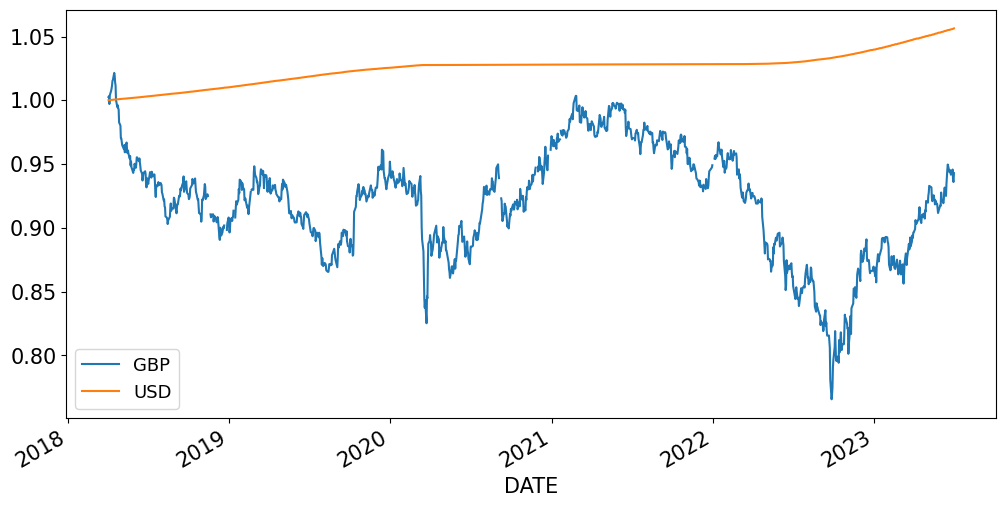

In [13]:
(rets+1).cumprod().plot();

## 1.2

The excess return of GBP is negative over this time.

In [14]:
rx = rets['GBP'] - rets['USD']
print(f'Mean excess return of carrying GBP is {rx.mean() * FREQ:.2%}')

Mean excess return of carrying GBP is -2.55%


## 1.3

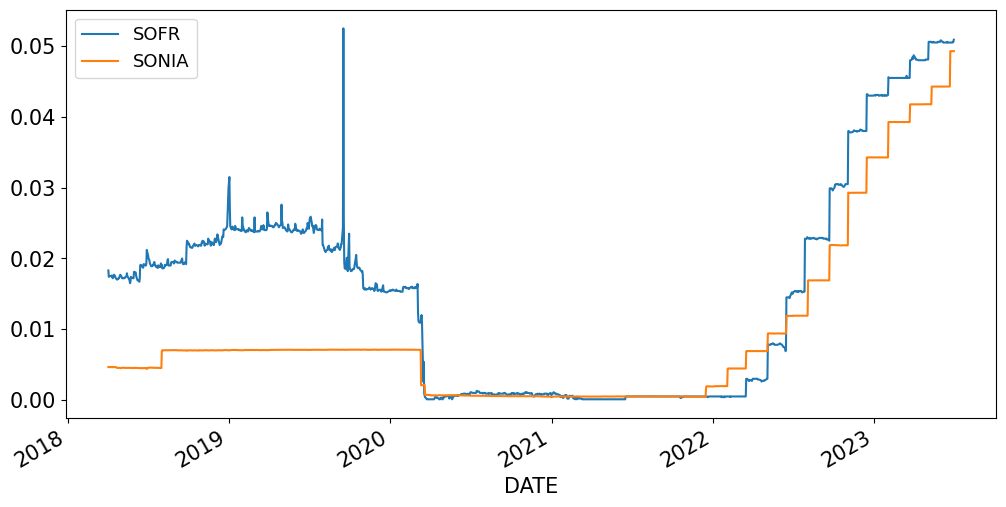

In [15]:
rates.plot();

In [16]:
rates.mean().to_frame().style.format('{:.2%}')

,0
SOFR,1.54%
SONIA,0.91%


The USD interest rate was higher on average, so the proper **carry** trade would have been to be long USD and short GBP.

This would work as follows:
1. $T_1$
* Borrow GBP at the SONIA rate
* Sell the (borrowed) GBP for USD at the spot exchange rate
* Invest the USD at the SOFR rate

2. $T_2$
* Take the USD (including SOFR return),
* Buy GBP at the spot exchange rate sufficient to close out the short position

This will have an excess return (in terms of GBP) of

$$\frac{S_{t}}{S_{t+1}}R_{t,t+1}^{\$} - R^*_{t,t+1}$$

or in terms of USD, this excess return is

$$S_{t}R_{t,t+1}^{\$} - S_{t+1}R^*_{t,t+1}$$

In [17]:
rx_short = pd.DataFrame(dtype=float,index=rates.index)
rx_short['GBP'] = fx['USUK'].shift() * (1+rates['SOFR']/FREQ)  - fx['USUK'] * (1+rates['SONIA']/FREQ)
rx_short.rename(columns={'GBP':'Short GBP'},inplace=True)

perf = pd.DataFrame(index=['Long GBP','Short GBP'],dtype=float,columns=['average (annualized) excess return (USD)'])
perf.loc['Long GBP'] = rx.mean() * FREQ
perf.loc['Short GBP'] = rx_short.mean()[0] * FREQ
perf.style.format('{:.1%}')

,average (annualized) excess return (USD)
Long GBP,-2.5%
Short GBP,4.3%


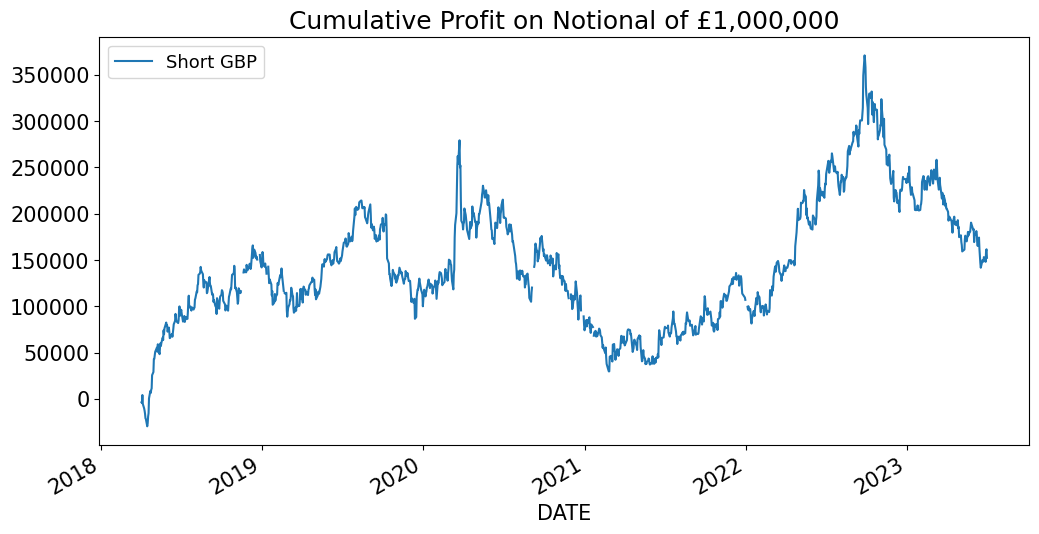

In [18]:
NOTIONAL_GBP = 1e6
(NOTIONAL_GBP * rx_short).cumsum().plot(title=f'Cumulative Profit on Notional of £{NOTIONAL_GBP:,.0f}');